In [10]:
import torch 
import torch.nn as nn
import os
import argparse
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import sys
from PIL import Image
import requests
from io import BytesIO
import urllib.request as url_req
import pickle
from Model import get_model
from utils import *
import json
from model_and_data import Data
from FGSM import FGSM
from visualize import visualise

In [13]:
device = torch.device('cpu')
model = get_model(device)                  # loads a pretrained vgg11 model
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [47]:
class BIM(object):
    def __init__(self,model,criterion,orig_img,orig_label,eps,alpha):
        self.model = model
        self.criterion = criterion
        self.orig_img = orig_img.clone()
        self.eps = eps
        self.orig_label = orig_label
        self.alpha = alpha
        self.img_bim = torch.tensor(orig_img.data,requires_grad=True)
        self.num_iters = math.ceil(min(self.eps+4,1.25*self.eps))
#         self.num_iters = 4
    def attack(self):
        loss_arr = []
        
        output_tr = self.model(self.orig_img)
        op_probs = F.softmax(output_tr,dim=1)
        pred_prob = ((torch.max(op_probs.data, 1)[0][0]) * 100, 4)
        _,pred_label = torch.max(output_tr.data,1)
        
        # iterative attack
#         print('Iters',self.num_iters)
        for i in range(self.num_iters):
#             print(i)



            output = self.model(self.img_bim)
#             print(type(output))
#             print(type(self.label))
            loss = self.criterion(output, self.orig_label)
#             print(loss)
            loss.backward()
            delta = self.alpha * torch.sign(self.img_bim.grad.data)
            self.img_bim = torch.tensor(self.img_bim.data + delta, requires_grad=True) # adversary without clipping
            
            clipped_delta = torch.clamp(self.img_bim.data-self.orig_img.data, -self.eps,self.eps) #clipping the delta
            self.img_bim = torch.tensor(self.orig_img.data+clipped_delta,requires_grad=True) # adding the clipped delta to original image
            loss_arr.append(loss)
        return pred_label,pred_prob[0],self.img_bim, clipped_delta, loss_arr

     

Iters 1
Unpert Top 1 Accuracy : 1.0
Unpert Top 5 Accuracy : 1.0
Top 1 Accuracy : 0.996
Top 5 Accuracy : 0.996


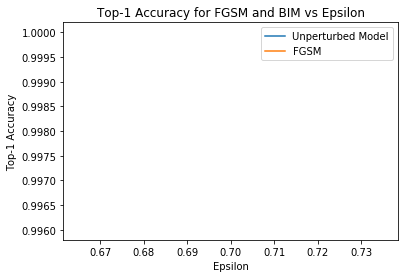

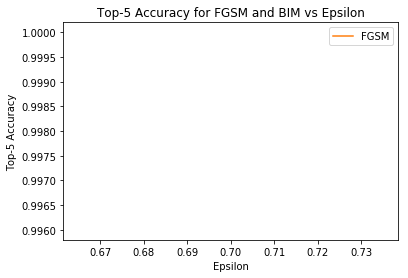

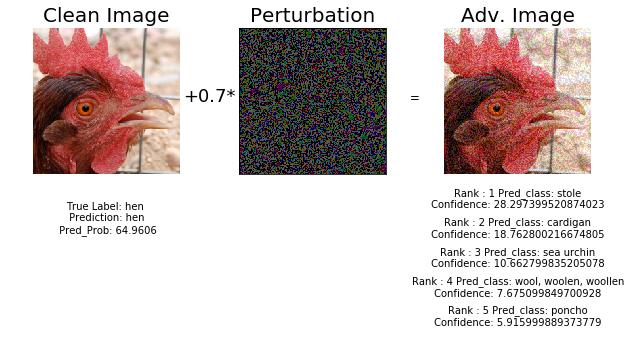

In [58]:
imgs = os.listdir('imagenet_imgs/')

# epsilon_arr = list(np.linspace(0,1,21))
# epsilon_arr = [0.05,0.01]
epsilon_arr = [0.7]
batch_size = len(os.listdir('imagenet_imgs/'))
top_one_acc_arr = []
top_five_acc_arr = []
unpert_top_one_acc = []
unpert_top_five_acc = []

for epsilon in epsilon_arr:
    unpert_top_one_misclassfns = 0
    unpert_top_five_misclassfns = 0
    top_one_misclassfns = 0
    top_five_misclassfns = 0

    for idx,img_name in enumerate(imgs):
        if idx==1:
            img_path = os.path.join('imagenet_imgs/',img_name)
            data = Data(model,device, None,None)
            img_tsor = data.preprocess_data(Image.open(img_path))
    #         imshow(img_tsor,'dgs')
            img_tsor.unsqueeze_(0)
            img_tsor = img_tsor.to(device)
            img_tsor.requires_grad_(True)

            label = img_name.split('_')[0]
            label = torch.tensor([int(label)],requires_grad=False)
            label = label.to(device)
    #         print(label.shape)

            criterion = nn.CrossEntropyLoss()

#             epsilon = 0.1
#             fgsm = FGSM(model,criterion,img_tsor,label,epsilon)
#     #         print(img_tsor.shape)
#             pred_label,pred_prob,adv_img,perturbation = fgsm.attack()
            alpha = 1
            bim = BIM(model,criterion,img_tsor,label,epsilon,epsilon/2)
            
            pred_label,pred_prob,adv_img,perturbation,loss = bim.attack()
            unpert_top_probs, unpert_top_labels = predict_top_five(model,img_tsor,k=5)
        
            
            output_adv = model(torch.tensor(adv_img))
            _,pred_adv = torch.max(output_adv.data,1)
        #     print(adv_img.data-img.data)
            op_adv_probs = F.softmax(output_adv, dim=1)                 #get probability distribution over classes
            adv_pred_prob =  ((torch.max(op_adv_probs.data, 1)[0][0]) * 100, 4)      #find probability (confidence) of a predicted class

            top_probs,top_labels = predict_top_five(model,adv_img,k=5)

    #         print(int(label),int(pred_adv))
            
            if (int(label)!=int(pred_label)):
                unpert_top_one_misclassfns+=1
                print('Whaaatttt')
            
            if (int(label) not in unpert_top_labels.astype(int)):
                unpert_top_five_misclassfns+=1
            
            if (int(label)!=int(pred_adv)):
                top_one_misclassfns+=1

            if(int(label) not in top_labels.astype(int)):
                top_five_misclassfns+=1
                
    unpert_top_one_acc.append(1-(unpert_top_one_misclassfns/batch_size))
    unpert_top_five_acc.append(1-(unpert_top_five_misclassfns/batch_size))
    top_one_acc_arr.append(1-(top_one_misclassfns/batch_size))
    top_five_acc_arr.append(1-(top_five_misclassfns/batch_size))
    
    print('Unpert Top 1 Accuracy :',1-(unpert_top_one_misclassfns/batch_size))
    print('Unpert Top 5 Accuracy :',1-(unpert_top_five_misclassfns/batch_size))
    print('Top 1 Accuracy :',1-(top_one_misclassfns/batch_size))
    print('Top 5 Accuracy :',1-(top_five_misclassfns/batch_size))
    
plt.figure()
plt.title('Top-1 Accuracy for FGSM and BIM vs Epsilon')
plt.plot(epsilon_arr,unpert_top_one_acc, label='Unperturbed Model')
plt.plot(epsilon_arr,top_one_acc_arr,label='FGSM')
plt.ylabel('Top-1 Accuracy')
plt.xlabel('Epsilon')
plt.legend()


plt.figure()
plt.title('Top-5 Accuracy for FGSM and BIM vs Epsilon')
plt.plot(epsilon_arr,unpert_top_five_acc)
plt.plot(epsilon_arr,top_five_acc_arr,label='FGSM')
plt.ylabel('Top-5 Accuracy')
plt.xlabel('Epsilon')
plt.legend()
plt.show()
visualise(img_tsor,perturbation,adv_img,label,label,pred_prob,pred_adv,adv_pred_prob,epsilon,top_probs,top_labels)
